In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels

In [4]:
from rkhs import compute_shifted_coverage, compute_adaptive_threshold
from Synthetic_data_generation import generate_cqr_data
from rkhs import runCV

100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


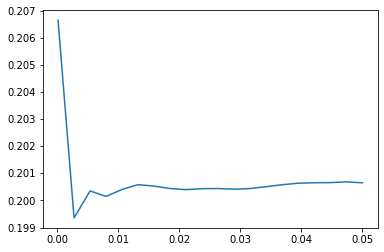

100%|███████████████████████████████████████████| 40/40 [09:26<00:00, 14.16s/it]


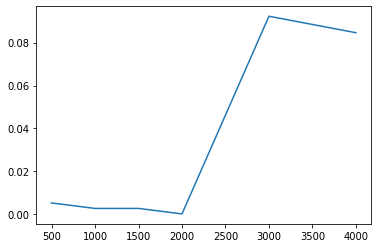

In [15]:
def run_one_cv_trial(alpha, gamma, k = 5, n_train=[1000],
                     num_lamb=30,min_lamb=0.0001, max_lamb=1):    
    
    x_train_final, y_train_final, x_calib, y_calib, _, _ = generate_cqr_data(n_train = 2*max(n_train),
                                                                             n_test = 2)
    reg = LinearRegression().fit(x_train_final, y_train_final)
    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    
    lossList = []
    lambdaList = []
    bestLamb = []
    for i in range(len(n_train)):
        allLosses, lambdas = runCV(x_calib[0:n_train[i],:],scores_calib[0:n_train[i]],
                                   "rbf",gamma,alpha,k,num_lamb=num_lamb,
                                   min_lamb = min_lamb,max_lamb=max_lamb)
        lossList.append(allLosses)
        lambdaList.append(lambdas)
        bestLamb.append(lambdas[np.argmin(allLosses)])
    return lossList, lambdaList, bestLamb

alpha = 0.9
gamma = 2
allLosses, lambdas, bestLamb = run_one_cv_trial(alpha, gamma, k = 5,
                                                n_train=[500],num_lamb=20,
                                                min_lamb=0.0001,max_lamb=0.05)
plt.plot(lambdas,allLosses)
plt.show()

minLamb = []
lossList = []
lossList, lambdaList, minLamb = run_one_cv_trial(alpha, gamma, k = 5,
                                          n_train=[250,500,750,1000,1500,2000],
                                          num_lamb=40,min_lamb=0.0001,max_lamb=0.1)

plt.plot([500,1000,1500,2000,3000,4000],minLamb)
plt.show()


[0.005223076923076923,
 0.0026615384615384613,
 0.0026615384615384613,
 0.0001,
 0.09231538461538462,
 0.08463076923076923]

In [22]:
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data()

reg = LinearRegression().fit(x_train_final, y_train_final)

def run_cv_synthetic_trial(reg, alpha, gamma, n_test, shift_loc, k = 5,
                        num_lamb=20,min_lamb=0.0001, max_lamb=0.1,n_train=2000):
    _, _, x_calib, y_calib, x_test, y_test = generate_cqr_data(n_train=n_train,n_test=n_test)

    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    scores_test = np.abs(reg.predict(x_test) - y_test)
    
    allLosses, lambdas = runCV(x_calib,scores_calib,"rbf",gamma,alpha,k,
                               num_lamb=num_lamb,min_lamb = min_lamb,max_lamb=0.01)
    lamb = lambdas[np.argmin(allLosses)]
    print(lamb)
        
    est_coverage, weighted_coverage, thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test[0:n_test,],
        shift_loc,
        kernel="rbf",
        alpha=alpha,
        radius=1/lamb,
        gamma=gamma
    )
    
    return est_coverage, weighted_coverage

n_trials = 10
alpha = 0.9
n_test = 100
n_train = 2000
gamma = 2
num_lamb=20
min_lamb=0.00001
max_lamb=0.1
shift_locs = [3.5, 4.5] #[0.5, 1.4, 2.5, 3.5, 4.5]

df = pd.DataFrame()

for shift_loc in shift_locs:
    est_coverages = []
    emp_coverages = []
    for i in range(n_trials):
        #try:
        est_cov, emp_cov = run_cv_synthetic_trial(reg, alpha, gamma, n_test, shift_loc, k = 5,
                        num_lamb=num_lamb,min_lamb=min_lamb, max_lamb=max_lamb,n_train=n_train)
        est_coverages.append(est_cov)
        emp_coverages.append(emp_cov)
        print(f"Trial {i}: {est_cov}, {emp_cov}")
        #except SolverError:
        #    continue
    a_df = pd.DataFrame({'empirical coverage' : emp_coverages, 'estimated coverage': est_coverages})
    a_df['shift_loc'] = shift_loc
    df = pd.concat([df, a_df], axis=0)

print(df)

100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.72s/it]


0.0015873684210526318


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Trial 0: 0.902106934908486, 0.9443955721052258


100%|███████████████████████████████████████████| 20/20 [00:55<00:00,  2.75s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Trial 1: 0.900973407218894, 0.8813559319272743


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]


0.004742105263157895


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Trial 2: 0.9053556233820341, 0.8443798981241896


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.54s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Trial 3: 0.9008699798622236, 0.8525258711820891


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.75s/it]


0.0015873684210526318


100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Trial 4: 0.9024694596360929, 0.9110903152625264


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.49s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Trial 5: 0.9003716789354872, 0.8461709235981342


100%|███████████████████████████████████████████| 20/20 [00:55<00:00,  2.75s/it]


0.0021131578947368424


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Trial 6: 0.9042685150553731, 0.8643209326616639


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.41s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [43:14<00:00, 25.95s/it]


Trial 7: 0.9005990409179102, 0.8846343378923356


100%|███████████████████████████████████████████| 20/20 [00:47<00:00,  2.37s/it]


0.0015873684210526318


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Trial 8: 0.9024933143608295, 0.8073922970842413


100%|███████████████████████████████████████████| 20/20 [00:46<00:00,  2.32s/it]


0.0010615789473684212


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Trial 9: 0.9013840177627819, 0.9667117096471239


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.73s/it]


0.0010615789473684212


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Trial 0: 0.8984181298474032, 0.8741862794643804


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.50s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Trial 1: 0.8991579604209948, 0.7856856059107726


100%|███████████████████████████████████████████| 20/20 [00:53<00:00,  2.68s/it]


0.0015873684210526318


100%|█████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Trial 2: 0.8982936542437518, 0.8689015254849907


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Trial 3: 0.8986078859094547, 0.8427074200738903


100%|███████████████████████████████████████████| 20/20 [00:45<00:00,  2.27s/it]


0.007371052631578948


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Trial 4: 0.8703627153716236, 0.8995836283819656


100%|███████████████████████████████████████████| 20/20 [00:47<00:00,  2.36s/it]


0.005267894736842105


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Trial 5: 0.8875241244090811, 0.8958875995736183


100%|███████████████████████████████████████████| 20/20 [00:53<00:00,  2.70s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Trial 6: 0.8987458419616605, 0.8720758258969614


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.41s/it]


0.01


100%|█████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Trial 7: 0.8728938788734242, 0.9657224614009288


100%|███████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


0.0036905263157894744


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Trial 8: 0.8831913762942242, 0.9906401320375507


100%|███████████████████████████████████████████| 20/20 [00:47<00:00,  2.39s/it]


0.0005357894736842106


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]

Trial 9: 0.8986369033210068, 0.9999999813871331
   empirical coverage  estimated coverage  shift_loc
0            0.944396            0.902107        3.5
1            0.881356            0.900973        3.5
2            0.844380            0.905356        3.5
3            0.852526            0.900870        3.5
4            0.911090            0.902469        3.5
5            0.846171            0.900372        3.5
6            0.864321            0.904269        3.5
7            0.884634            0.900599        3.5
8            0.807392            0.902493        3.5
9            0.966712            0.901384        3.5
0            0.874186            0.898418        4.5
1            0.785686            0.899158        4.5
2            0.868902            0.898294        4.5
3            0.842707            0.898608        4.5
4            0.899584            0.870363        4.5
5            0.895888            0.887524        4.5
6            0.872076            0.898746        4.

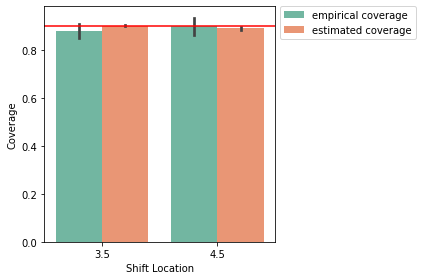

In [23]:
import seaborn as sns
import pandas as pd

melted_df = pd.melt(df, id_vars=['shift_loc'], value_vars=['empirical coverage', 'estimated coverage'])
melted_df = melted_df.rename(columns={"shift_loc": "Shift Location", "value": "Coverage"})

fig = sns.barplot(
    melted_df, 
    x='Shift Location', 
    y='Coverage',
    hue='variable',
    palette=sns.color_palette("Set2")
)
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

fig.get_figure().savefig('synthetic_rkhs_coverage.png')
